import libraries and read data

In [50]:
# we have to install the development version for the time being
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal@landsat-dev

#!pip install --upgrade git+https://github.com/EOA-team/eodal
#!pip install --upgrade planetary-computer

# Print EOdal version
#import eodal
#print("Version of EOdal: " + eodal.__version__)

In [51]:
# Import general libraries
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

# Import EOdal libraries
from eodal.core.band import Band
from eodal.core.raster import RasterCollection

# Import scikit-learn libraries
import sklearn
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

In [52]:
#year to cluster
year = 2021

In [53]:
#read tif from disk:
fpath_raster = Path(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_{year}_smallAOI.tif')

# initialize a RasterCollection from the .tif file
composite = RasterCollection.from_multi_band_raster(fpath_raster=fpath_raster,
                                                    band_names_dst= ['blue_median','green_median','red_median','nir08_median','swir16_median','swir22_median'],
                                                    band_aliases = ["blue", "green", "red", "nir_1", "swir_1","swir_2"])

# calculate some SI
composite.calc_si('NDVI', inplace = True)
composite.calc_si('NDWI', inplace = True)
composite.calc_si('EVI', inplace = True)
composite.calc_si('CI_GREEN', inplace = True)
composite.calc_si('MSAVI', inplace = True)
composite.calc_si('BSI', inplace = True)

# print band summaries
composite.band_summaries()

,min,mean,std,max,count,geometry,band_name
0,0.077155,0.081507,0.002161,0.110410,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",blue_median
1,0.083210,0.090886,0.004251,0.135910,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",green_median
2,0.079020,0.085550,0.004297,0.156500,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",red_median
3,0.087570,0.184072,0.022578,0.248670,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",nir08_median
4,0.078815,0.126920,0.014209,0.242330,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",swir16_median
5,0.076170,0.098142,0.008388,0.179640,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",swir22_median
6,0.047778,0.360511,0.062971,0.494187,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",NDVI
7,-0.455743,-0.334119,0.060715,-0.021696,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",NDWI
8,0.020682,0.225766,0.046593,0.359439,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",EVI
9,0.044355,1.023185,0.218864,1.674734,19604.0,"POLYGON ((873345.000 55905.000, 873345.000 593...",CI_GREEN


In [54]:
# Create a DataFrame from the RasterCollection
gdf = composite.to_dataframe()

gdf.describe()

,blue_median,green_median,red_median,nir08_median,swir16_median,swir22_median,NDVI,NDWI,EVI,CI_GREEN,MSAVI,BSI
count,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000
mean,0.081507,0.090886,0.085550,0.184072,0.126920,0.098142,0.360511,-0.334119,0.225766,1.023185,0.163270,-0.110583
std,0.002161,0.004251,0.004297,0.022579,0.014209,0.008388,0.062973,0.060716,0.046595,0.218870,0.034733,0.030412
min,0.077155,0.083210,0.079020,0.087570,0.078815,0.076170,0.047778,-0.455743,0.020682,0.044355,0.013788,-0.194750
25%,0.079795,0.086895,0.081984,0.174730,0.118385,0.091935,0.346222,-0.363650,0.208782,0.950328,0.149905,-0.130098
50%,0.081390,0.091260,0.085290,0.186280,0.127440,0.097740,0.369636,-0.343226,0.230104,1.045186,0.166216,-0.115056
75%,0.082850,0.093820,0.088070,0.197105,0.135470,0.103380,0.392453,-0.322109,0.251934,1.142922,0.183052,-0.096609
max,0.110410,0.135910,0.156500,0.248670,0.242330,0.179640,0.494187,-0.021696,0.359439,1.674734,0.267498,0.129094


In [55]:
from sklearn.preprocessing import MinMaxScaler

selected_columns = ['blue_median','green_median','red_median','nir08_median','swir16_median','swir22_median','NDVI','NDWI','EVI','CI_GREEN','MSAVI','BSI']

## Step 1: Extract the feature columns from the GeoDataFrame into a NumPy array
features = gdf[selected_columns].values

## Step 2: Initialize the MinMaxScaler
scaler = MinMaxScaler()

## Step 3: Fit the scaler to the feature data
scaler.fit(features)

## Step 4: Transform the feature data using the fitted scaler
scaled_features = scaler.transform(features)

## Step 5: Replace the original feature values in the GeoDataFrame with the scaled values
gdf[selected_columns] = scaled_features

gdf[selected_columns].describe()


,blue_median,green_median,red_median,nir08_median,swir16_median,swir22_median,NDVI,NDWI,EVI,CI_GREEN,MSAVI,BSI
count,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000
mean,0.130866,0.145646,0.084278,0.599017,0.294191,0.212348,0.700553,0.280209,0.605402,0.600370,0.589184,0.259900
std,0.064980,0.080672,0.055461,0.140153,0.086898,0.081070,0.141065,0.139884,0.137545,0.134245,0.136900,0.093908
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.079387,0.069924,0.038252,0.541030,0.241996,0.152363,0.668545,0.212174,0.555265,0.555682,0.536506,0.199638
50%,0.127349,0.152751,0.080924,0.612725,0.297373,0.208466,0.720993,0.259229,0.618208,0.613864,0.600797,0.246086
75%,0.171252,0.201328,0.116804,0.679919,0.346482,0.262975,0.772106,0.307879,0.682650,0.673811,0.667156,0.303049
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
# Get the colors from the "Accent" colormap
cmap = plt.get_cmap('Accent')
colors = cmap.colors
values = np.arange(8)

c:\Users\ftimcke\AppData\Local\anaconda3\envs\lulc\Lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


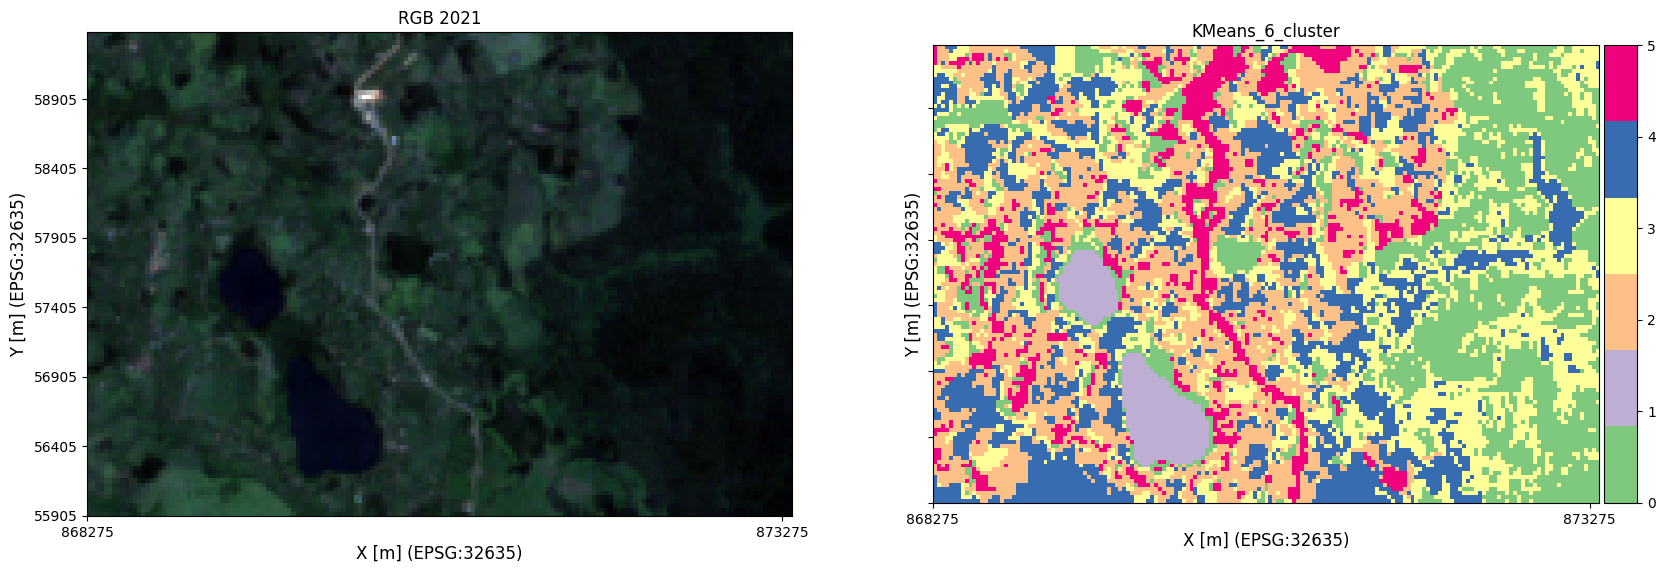

In [57]:
## Use K-means for Clustering:

# set the desired number of clusters for KMean and GMM

for n in range(6, 7, 1):

    # create model
    km = KMeans(n_clusters = n, n_init = 'auto') 

    # fit the model to the data
    km.fit(scaled_features)

    # Get the cluster labels
    labels = km.labels_

    # Calculate the scores
    #silhouette = silhouette_score(scaled_features, labels)
    #calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    #davies_bouldin = davies_bouldin_score(scaled_features, labels)

    # Print the scores
    #print(f'kmeans, {n}, Silhouette score, {silhouette}')
    #print(f'kmeans, {n}, Calinski-Harabasz score, {calinski_harabasz}')
    #print(f'kmeans, {n}, Davies-Bouldin score, {davies_bouldin}')

    # Add the cluster labels to the DataFrame and show it
    gdf[f'KMeans_{n}_cluster'] = labels
        
    # create new band instance from a column in GeoDataFrame
    KMeans_cluster = Band.from_vector(vector_features = gdf,
                                 band_name_src = f'KMeans_{n}_cluster',
                                 geo_info = composite['blue'].geo_info,
                                 band_name_dst = f'KMeans_{n}_cluster'
                                 )

    #add column KMeans_cluster as a new Band into the RasterCollection composite
    composite.add_band(KMeans_cluster)
    
    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n])
    ticks = list(range(n))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'KMeans_{n}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'KMeans_{n}_cluster')
    
    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\KMeans_{n}_cluster_{year}.png')


Cluster labels: [2 2 2 ... 4 4 4]


c:\Users\ftimcke\AppData\Local\anaconda3\envs\lulc\Lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


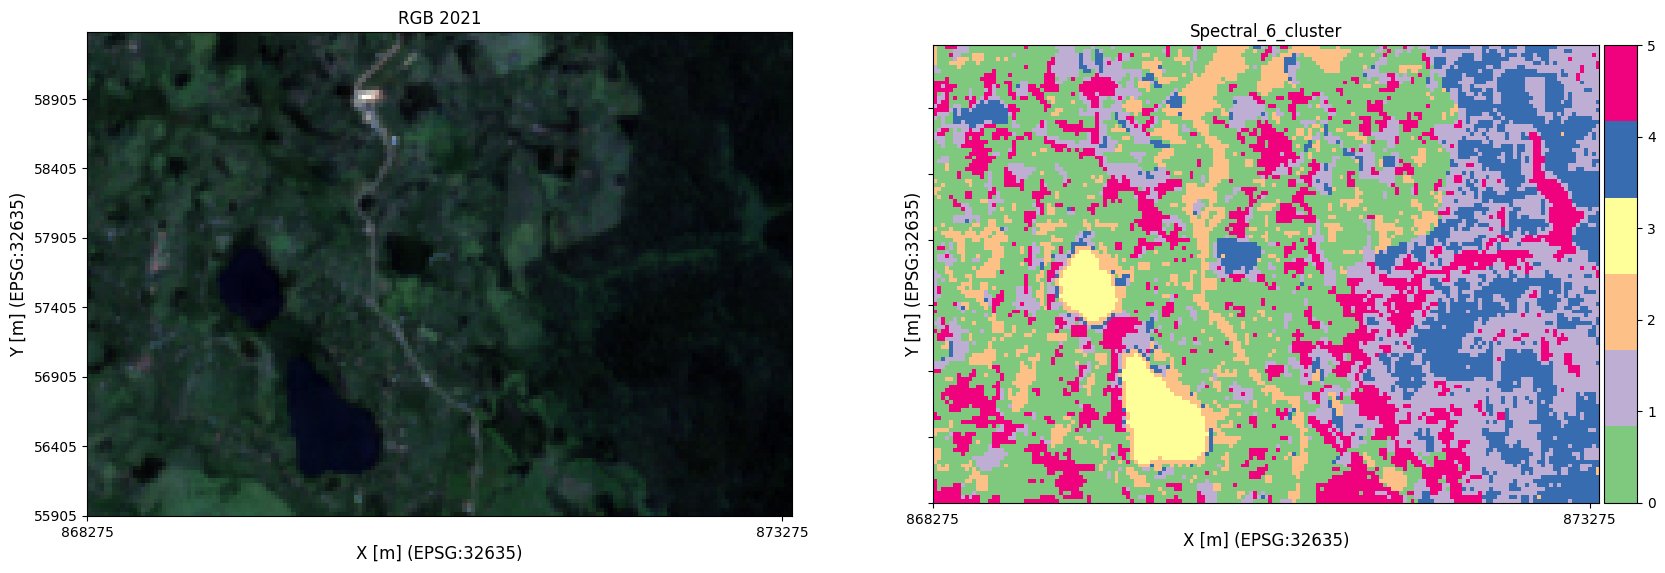

In [58]:
## Use Spectral Clustering for Clustering:

from sklearn.cluster import SpectralClustering

for n in range(6, 7, 1):
    
    # Assuming 'scaled_features' is your scaled data array
    # You need to set the appropriate values for these parameters
    n_clusters = n  # Number of clusters you want to find
    affinity_matrix = 'nearest_neighbors'  # Type of affinity matrix ('nearest_neighbors' or 'rbf')
    random_state = 42  # Random state for reproducibility

    # Create a SpectralClustering instance
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity=affinity_matrix, random_state=random_state)

    # Fit and predict the clusters
    cluster_labels = spectral_clustering.fit_predict(scaled_features)

    print("Cluster labels:", cluster_labels)

    # Assign cluster labels to GeoDataFrame
    gdf[f'Spectral_{n_clusters}_cluster'] = cluster_labels

    # create new band instance from a column in GeoDataFrame
    Spectral_cluster = Band.from_vector(vector_features = gdf,
                                    band_name_src = f'Spectral_{n_clusters}_cluster',
                                    geo_info = composite['blue'].geo_info,
                                    band_name_dst = f'Spectral_{n_clusters}_cluster')

    #add column GMM_cluster as a new Band into the RasterCollection composite
    composite.add_band(Spectral_cluster)

    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n_clusters])
    ticks = list(range(n_clusters))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'Spectral_{n_clusters}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'Spectral_{n_clusters}_cluster')

    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\Spectral_{n_clusters}_cluster_{year}.png')

c:\Users\ftimcke\AppData\Local\anaconda3\envs\lulc\Lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


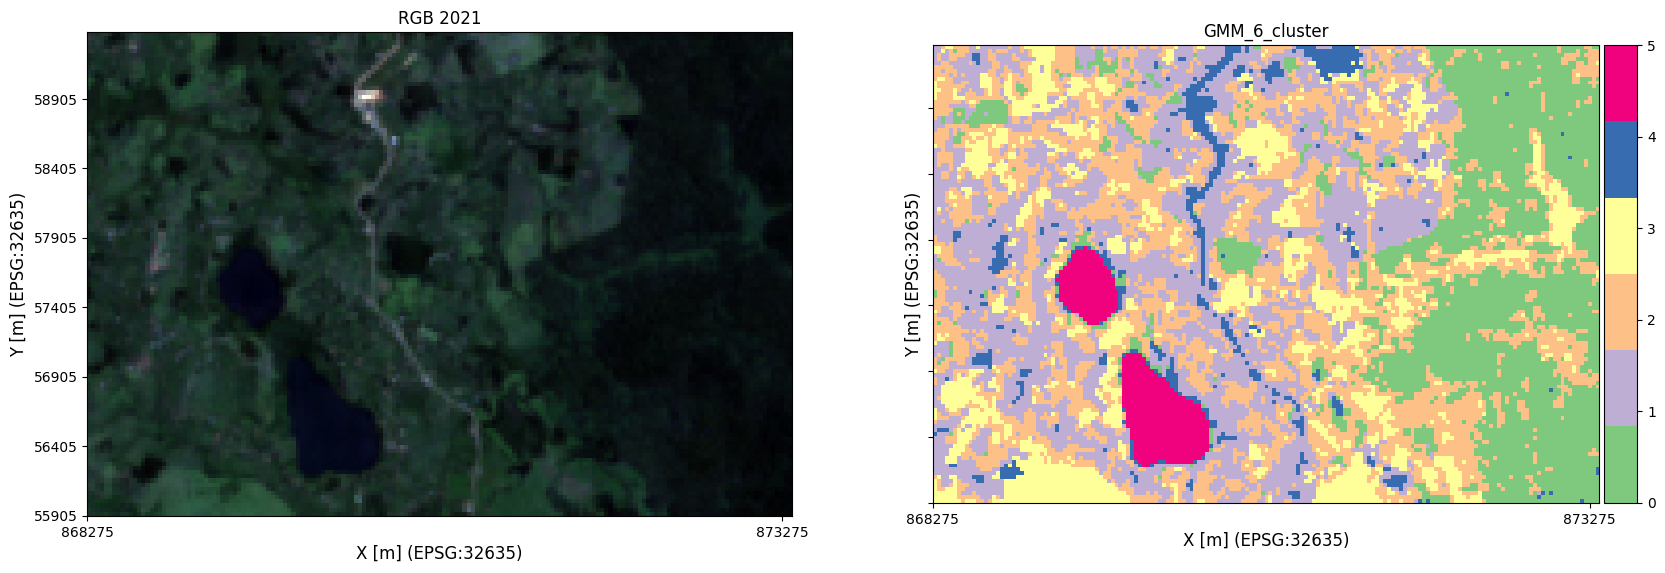

In [59]:
## Use Gaussian Mixture Models for Clustering:

for n in range(6, 7, 1):

    # create model
    gmm = GaussianMixture(n_components = n)

    # fit the model to the data
    gmm.fit(scaled_features)

    # Assign cluster labels
    GMM_cluster = gmm.predict(scaled_features)

    # Calculate the scores
    #silhouette = silhouette_score(scaled_features, labels)
    #calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    #davies_bouldin = davies_bouldin_score(scaled_features, labels)

    # Print the scores
    #print(f'gmm, {n}, Silhouette score, {silhouette}')
    #print(f'gmm, {n}, Calinski-Harabasz score, {calinski_harabasz}')
    #print(f'gmm, {n}, Davies-Bouldin score, {davies_bouldin}')

    # Assign cluster labels to GeoDataFrame
    gdf[f'GMM_{n}_cluster'] = GMM_cluster

    # create new band instance from a column in GeoDataFrame
    GMM_cluster = Band.from_vector(vector_features = gdf,
                                    band_name_src = f'GMM_{n}_cluster',
                                    geo_info = composite['blue'].geo_info,
                                    band_name_dst = f'GMM_{n}_cluster')

    #add column GMM_cluster as a new Band into the RasterCollection composite
    composite.add_band(GMM_cluster)
    
    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n])
    ticks = list(range(n))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'GMM_{n}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'GMM_{n}_cluster')
    
    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\GMM_{n}_cluster_{year}.png')

estimated bandwidth: 0.2904712383029549


c:\Users\ftimcke\AppData\Local\anaconda3\envs\lulc\Lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


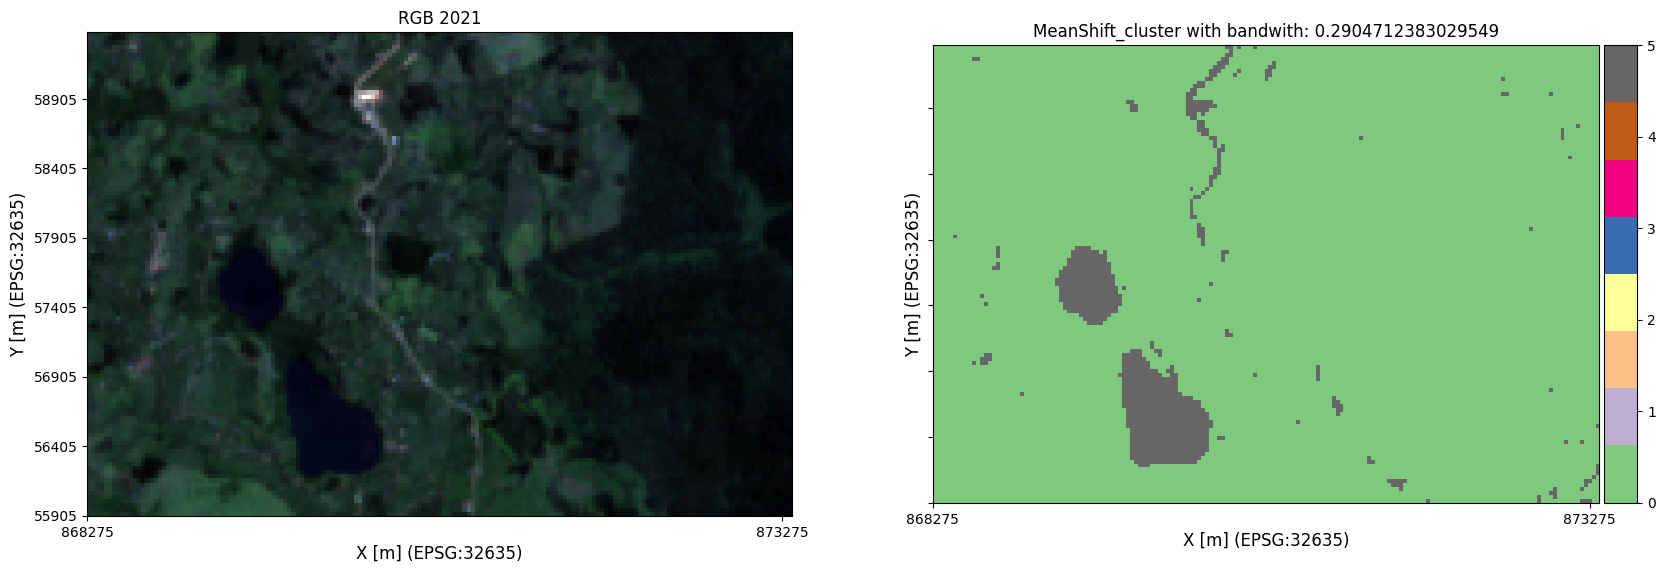

In [60]:
## Use MeanShift for Clustering:
from sklearn.cluster import estimate_bandwidth

bandwidth_est = estimate_bandwidth(scaled_features)
print(f'estimated bandwidth: {bandwidth_est}')

#define bandwidth for model
bandwidth = bandwidth_est

# create model
ms = MeanShift(bandwidth=bandwidth)

# fit the model to the data
ms.fit(scaled_features)

# Assign cluster labels
cluster_labels = ms.labels_

# Assign cluster labels to GeoDataFrame
gdf[f'MeanShift_cluster_{bandwidth}'] = cluster_labels

# add column cluster_mean_shift as a new Band into the RasterCollection composite
MeanShift_cluster = Band.from_vector(vector_features = gdf,
                                band_name_src = f'MeanShift_cluster_{bandwidth}',
                                geo_info = composite['blue'].geo_info,
                                band_name_dst=f'MeanShift_cluster_{bandwidth}')


composite.add_band(MeanShift_cluster)

#plot clusters
fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title(f'RGB {year}')

composite.plot_band(f'MeanShift_cluster_{bandwidth}', colormap='Accent', discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
axs[1].set_title(f'MeanShift_cluster with bandwith: {bandwidth}')

#save as PNG for quick view
fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\MS_cluster_{year}_{bandwidth}.png')


In [61]:
# save as GeoTiff
composite.to_rasterio(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_{year}_smallAOI_si_cluster.tif')